### 1. Introduction

The purpose of the lecture is to introduce you to some tools and techniques to analyse a new dataset. This is often beneficial, as it delivers statistical insights which could be used for training and gives you an impression of the data.
Due to the size a manual inspection is often not feasible.

We are going to analyse the RailSem19 (https://wilddash.cc/railsem19) dataset. This is a public dataset with 8500 front-facing images taken from moving train and trams with the pixel-wise semantic annotations.

Originally, the images had a resolution of 1920 by 1080 pixels. For faster processing, I have resized them to 480 by 270 pixels.


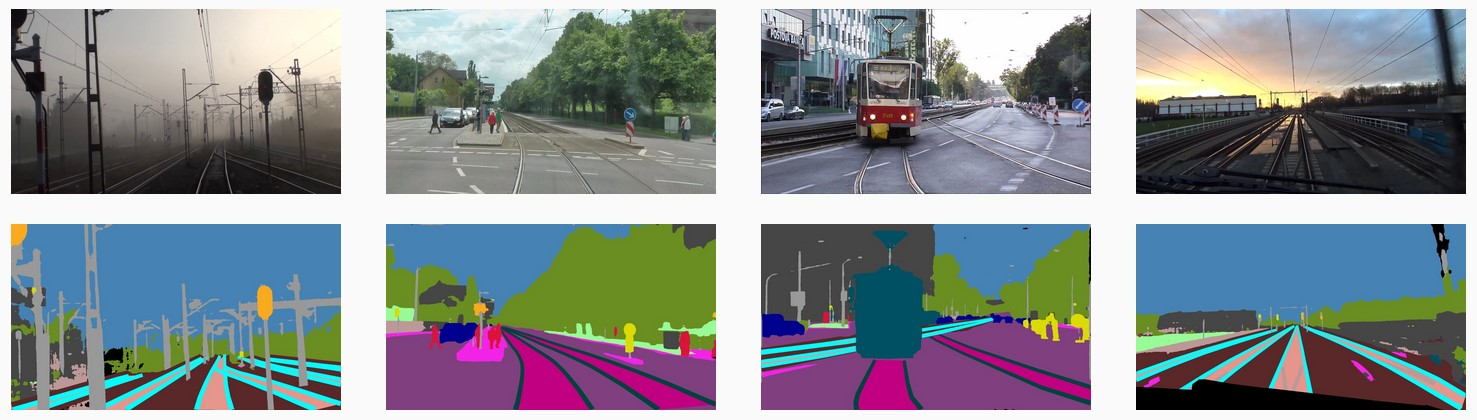

### 2. Prerequirities

The necessary stuff to import packages and get example data... you can run this code without reading it.

Please, before running the following code, access the link below, right click on the .zip file, then click "Add shortcut to Drive" and select your Drive folder:

https://drive.google.com/drive/folders/1s6Pj-2N0STFvsZiZX6HaU8WimABfH4R8?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -qq '/content/drive/MyDrive/resources_dnn4cv.zip'

from resources_dnn4cv.utils import plot_sample_from_dataset, visualize_feature_embedding

**Make shure to request GPUs from Colab!**

-> Small arrow in the top-right corner -> "View Resources" -> "Change runtime type" (in the bottom)

**Make a copy to allow saving!**

In [ ]:
!pip install umap-learn

### 2. Implementation dataset class

For a convinient handling of the data, we will abstract the process in a Pytorch [dataset class](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). Such a function must provide at least the following three functions:

1. `__init__`
    - initializes the class
    - should find and store the paths to all samples (usually in a list)
2. `__getitem__(idx)`
    - consumes an index
    - retrivies the associated path and loads the samples
    - (optionally) applies some transformations and augmentations
    - returns the sample (as tensor or dictionay of tensors)
3. `__len__`
    - return the number of samples (the length of the dataset)

**Task:** Complete the following dataset class for the RailSem19 dataset. As you can see, it should return a dictionary containing the RGB image and the annotation mask.

**Hints:**
- Check out [Path.glob](https://docs.python.org/3/library/pathlib.html#pathlib.Path.glob), as it really facilitates the search for files in directories.
- Use [torchvision.io.read_image](https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html)

In [ ]:
from torch.utils.data import Dataset

class RailSem19Dataset(Dataset):
    def __init__(self, data_dir: str):
        ...
        self.list_images = ...
        self.list_masks = ...

    def __len__(self):
        ...

    def __getitem__(self, idx):
        ...
        return {"image": rgb_image, "mask": gt_image}

In [ ]:
from torch.utils.data import Dataset
from pathlib import Path
import torch
from torchvision.io import read_image

class RailSem19Dataset(Dataset):
    def __init__(self, data_dir: str):

        super().__init__()

        self.data_dir = Path(data_dir)

        if not self.data_dir.is_dir():
            raise RuntimeError(str(self.data_dir) + " is not a directory!")

        self.rgb_files = sorted(
            list(self.data_dir.glob("./jpgs/rs19_val/*.jpg")), key=lambda i: int(i.stem[2:])
        )

        self.gt_files = sorted(
            list(self.data_dir.glob("./uint8/rs19_val/*.png")), key=lambda i: int(i.stem[2:])
        )

    def __len__(self):
        """Returns the length of the dataset."""
        return len(self.rgb_files)

    def __getitem__(self, index):
        """Returns a sample from the dataset."""
        if torch.is_tensor(index):
            index = index.tolist()

        rgb_file_path = str(self.rgb_files[index])
        gt_file_path = str(self.gt_files[index])

        rgb_image = read_image(rgb_file_path)
        gt_image = read_image(gt_file_path)

        return {"image": rgb_image, "mask": gt_image}

    def get_paths(self, index):
        """Returns the paths of the sample at the given index."""
        return {"image_path": self.rgb_files[index], "mask_path": self.gt_files[index]}

### 3. Initialize the datast

**Task:** Initialize the `RailSegm19Dataset` class with the correct path to the data and print the number of available samples (should be 8500, right?).

In [ ]:
data_dir = "/content/railsem19/railsem19"

dataset = ...

In [ ]:
data_dir = "/content/resources_dnn4cv/railsem19"

dataset = RailSem19Dataset(data_dir)
print(f"Dataset length: {len(dataset)}")

### 4. Visualize a random sample

**Task:** Randomly select a sample from the dataset and visualize it! Use the `utils.plot_samples_from_dataset` function!

In [ ]:
from resources_dnn4cv.utils import plot_sample_from_dataset

...

plot_sample_from_dataset(image, mask)

In [ ]:
from random import randint
from resources_dnn4cv.utils import plot_sample_from_dataset

rand_id = randint(0,len(dataset))
print(f"Random ID: {rand_id}")

sample = dataset[rand_id]

image = sample["image"]
mask = sample["mask"]

plot_sample_from_dataset(image, mask)

### 6. Feature Visualization

To visualize a given dataset, it is common practice to visualize the features of the different samples. Though, modern DNNs have very high/dimensional features spaces.
To allow insights, we need to reduce this to 2 or 3 dimensions.

#### 6.1 Feature Extraction

One possible way is to use pre-trained neural networks like Resnet, VGG, ... to extract features from given images.

**Task:** Find some implemented and pretrained DNN. Strip away classifier, encoder, ... part, to receive the intermediate features.
Calling `model(input_image)` should result in a BxN dimensional tensor, with B being the batch size and N the number of channels.

In [ ]:
...


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == "cpu":
  print("Have you forgotten to request for GPUs?")
num_devices = torch.cuda.device_count()
for i in range(num_devices):
  print(f"Device ({i}): {torch.cuda.get_device_name(0)}")

model = ...

In [ ]:
from torchvision.models.resnet import resnet18
from torchvision.models.resnet import ResNet18_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == "cpu":
  print("Have you forgotten to request for GPUs?")
num_devices = torch.cuda.device_count()
for i in range(num_devices):
  print(f"Device ({i}): {torch.cuda.get_device_name(0)}")

model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).to(device)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()

print("Model loaded!")

#### 6.2 Apply Feature Extraction

**Task:** Apply the model on the data. Extract the features for each sample in the dataset. Store them into an 8500xN dimensional numpy array!

In [ ]:
import numpy as np
from tqdm import tqdm

features = []

for sample in tqdm(dataset):
    ...
    features.append(...)

features = np.array(features)


In [ ]:
import numpy as np
from tqdm import tqdm

transform = ResNet18_Weights.IMAGENET1K_V1.transforms()
features = []

for sample in tqdm(dataset):
    input_image = sample["image"]
    input_image = transform(input_image).unsqueeze(0).to(device)

    features.append(model(input_image).detach().cpu().numpy())

features = np.array(features).squeeze()

print(f"Features shape: {features.shape}")

#### 6.3 Dimensionality Reduction with UMAP

UMAP stands for Uniform Manifold Approximation and Projection for Dimension Reduction.

It can be used for dataset visualization (similar to t-SNE, which I found to be more susceptible to the parameter setting) and for general non-linear dimension reduction.

The manifold of the data is modelled with a fuzzy topological structure. Stochastic Gradient Descent (SGD) is used to find a low dimensional projection which stays close to the fuzzy topological structure.

You can find a very good and understandable explanation here: [How UMAP Works](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html)

**Task:** Run UMAP on the feature matrix! For an explanation of the parameters see https://umap-learn.readthedocs.io/en/latest/parameters.html

In [ ]:
import umap

umap_emb = umap.UMAP(n_components=2,
  random_state=42 # for reproducibility
  ...
).fit_transform(features)

umap_emb_x = ...
umap_emb_y = ...

In [ ]:
import umap
umap_emb = umap.UMAP(n_neighbors=10,
    min_dist=0.1,
    n_components=2,
    random_state=42,
).fit_transform(features)

#### 6.4 Normalize

**Task:** For easier visualization write a small function that normalizes a one-dimensional numpy array (a vector) so that the points are in the [0:1] range. Apply it to both dimensions!

In [ ]:
def normalize_into_0_to_1(x):
    ...

umap_emb_x = ...
umap_emb_y = ...

In [ ]:
def normalize_into_0_to_1(x):
    return (x - x.min()) / (x.max() - x.min())

umap_emb_x = normalize_into_0_to_1(umap_emb[:, 0])
umap_emb_y = normalize_into_0_to_1(umap_emb[:, 1])

#### 6.5 Visualize

**Task:** Just run the subsequent script! Maybe adapt height, width, step_size and/or scale, if it takes too long (Does not take more than 1 minute on my workstation). If you hover with your cursor over the function's name, a tooltip opens and you can click "View Source".

Can you identify any clusters/ structure in the visualized data?

In [ ]:
from resources_dnn4cv.utils import visualize_feature_embedding

visualize_feature_embedding(dataset, umap_emb_x, umap_emb_y, scale=0.25, step_size=1)

### 6.6 Plot unusual samples

**Task:** Calculate the mean feature vector over all samples.


In [ ]:
mean_feature_val = ...

In [ ]:
mean_feature_val = np.mean(features, axis=0)

**Task:** Calculate the L2-Norm (Euclidean) between each feature vector and the mean feature vector. Sort the entries! From highest to lowest!

In [ ]:
dist_values = []

for f in tqdm(features):
  dist_values.append( ... )

In [ ]:
dist_values = []

for f in tqdm(features):
  dist_values.append( np.linalg.norm(mean_feature_val - f) )

sorted_indices = np.argsort(dist_values)
sorted_indices = sorted_indices[::-1]


**Task:** Plot and analyze some of the samples with the highest differences!

In [ ]:
i = 20

In [ ]:
...
plot_sample_from_dataset(...)
...

In [ ]:
idx = sorted_indices[i]
print(f"i: {i}, Index: {idx}, Distance: {dist_values[idx]}")
image, mask = dataset[idx].values()
plot_sample_from_dataset(image, mask)
i = i + 1

### 7. Class label analysis

**Task:** Write a code snippet that creates a NxC numpy array, with N being the number of samples and C the number of classes (20), storing the number of pixel assigned to each class!

In [ ]:
def get_num_pixels_each_class(mask):
    ...

features_num_pixels = []

for sample in tqdm(dataset):
    input_mask = sample["mask"]

    features_num_pixels.append(get_num_pixels_each_class(input_mask))

features_num_pixels = np.array(features_num_pixels).squeeze()

print(f"Features shape: {features_num_pixels.shape}")

In [ ]:
def get_num_pixels_each_class(mask):
    pixels_each_class = []

    for i in range(0, 20):
        m = torch.zeros(mask.size())

        if i < 19:
            m[mask == i] = 1
        else:
            m[mask ==255] = 1

        pixels_each_class.append( torch.sum(m).item() )

    np_pixels_each_class = np.asarray(pixels_each_class)

    assert np.sum(np_pixels_each_class) == np.prod(mask.size())

    return np_pixels_each_class


features_num_pixels = []

for sample in tqdm(dataset):
    input_mask = sample["mask"]

    features_num_pixels.append(get_num_pixels_each_class(input_mask))

features_num_pixels = np.array(features_num_pixels).squeeze()

print(f"Features shape: {features_num_pixels.shape}")



**Task:** Use PCA to reduce the number of components to two! Normalize again!

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

...

pca_emb_x = ...
pca_emb_y = ...

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_emb = pca.fit_transform(features_num_pixels)

pca_emb_x = normalize_into_0_to_1(pca_emb[:, 0])
pca_emb_y = normalize_into_0_to_1(pca_emb[:, 1])

**Task:** Visualize!

In [ ]:
visualize_feature_embedding(dataset, pca_emb_x, pca_emb_y, step_size=10)

**Task:** Calculate the euclidean distance to the center (0.5, 0.5) for all samples and sort them from large to small.

In [ ]:
dist = ...

In [ ]:
dist = np.sqrt( (pca_emb_x - 0.5)**2 + (pca_emb_y - 0.5)**2 )
indices = np.argsort(dist)

indices = indices[::-1]

**Task:** Plot some of the samples! Begin with the largest distance values!

In [ ]:
i = 0

In [ ]:
...
plot_sample_from_dataset(image, mask)
i = i + 1

In [ ]:
idx = indices[i]
print(f"i: {i}, Index: {idx}")
image, mask = dataset[idx].values()
plot_sample_from_dataset(image, mask)
i = i + 1


### 8. Conclusion

How do you "feel" about this dataset? Would you rely on it to train a semantic segmentation network?

You are among the first students working with this notebook. Please let me know if you had any troubles. I hope you learned something along the way and won't use your next new dataset right head on without analyzing it.